In [1]:
import ast
import gzip
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from tqdm import tqdm

%matplotlib inline

# Загрузка данных

In [2]:
test_df = pd.read_csv('..\\input\\mlboot_test.tsv')
train_df = pd.read_csv('..\\input\\mlboot_train_answers.tsv', delimiter='\t')

#### Загрузка всего датасета с признаками (WARNING - MEMORY)

In [ ]:
# Загрузка
dataset = pd.read_csv('..\\input\\mlboot_data.tsv', delimiter='\t', header=None, 
                      names=['cuid', 'cat_feature', 'counter1', 'counter2', 'counter3', 'dt_diff'])

# Сохранить тестовые данные для возможных экспериментов
# dataset.loc[:100, :].to_csv('..\\input\\test_df.csv', sep='\t', header=None, index=False)

In [ ]:
print('Dataset:\n', dataset.head(), '\n')
print('Test df\n', test_df.head(), '\n')
print('Train df\n', train_df.head())

In [4]:
print('Размерность dataset', dataset.shape)
print('Размерность test_df', test_df.shape)
print('Размерность train_df', train_df.shape)

Размерность dataset (19528597, 6)
Размерность test_df (181024, 1)
Размерность train_df (427994, 2)


# Simple EDA

#### Сбалансированность выборки

In [6]:
train_df.groupby('target').count()

,cuid
target,
0,406542
1,21452


##### Количество дней до даты

In [5]:
dataset['dt_diff'].describe()

count    1.952860e+07
mean     3.032207e+01
std      1.733587e+01
min      1.000000e+00
25%      1.500000e+01
50%      3.000000e+01
75%      4.500000e+01
max      6.000000e+01
Name: dt_diff, dtype: float64

##### Распределение количества дней до даты опроса

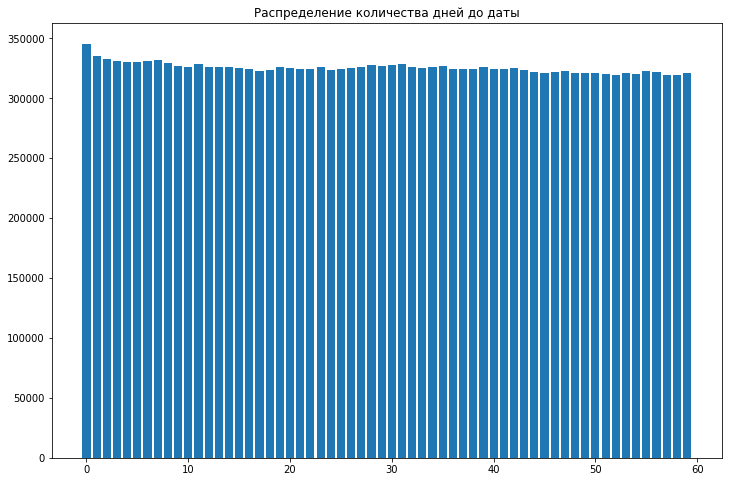

In [15]:
dt_diff = dataset['dt_diff'].value_counts().sort_index()
plt.figure(figsize=(12,8))
plt.bar(range(dt_diff.shape[0]), dt_diff)
plt.title('Распределение количества дней до даты')
plt.show()

##### Статистика по уникальным идентификаторам

In [6]:
dataset['cuid'].value_counts().describe()

Статистика по уникальным идентификаторам


count     6.000000
mean     16.833333
std      18.967516
min       1.000000
25%       3.250000
50%       8.000000
75%      32.250000
max      42.000000
Name: cuid, dtype: float64

##### Распределение идентификаторов на группы cat_feature

In [10]:
dataset[['cuid', 'cat_feature']].groupby('cat_feature').count()

,cuid
cat_feature,
1,6
2,85
5,10


##### Уникальные идентификаторы

In [17]:
cuids = dataset['cuid'].unique()
print('Кол-во:', cuids.shape[0])

Кол-во: 6


# Проверка датасета на последовательность записи cuid
возможно все cuid идут последовательно (не перемешаны)
Создать файл только с данными cuid из начального датасета, пропуская строки с повторением cuid

In [ ]:
%%time

niter = 0
input_gzip = '..\\input\\mlboot_data.tsv.gz'
output_cuids = '..\\vw\\cuid_unique_consistently.vw'

prev_cuid = ''
with gzip.open(input_gzip, 'rt') as input_data, open(output_cuids, 'w') as output:

    for row in tqdm(input_data):
        cuid = row.split()[0]
        
        if cuid != prev_cuid:
            output.write(f'{cuid}\n')
        
        prev_cuid = cuid

In [ ]:
Проверить количество cuid в записанном файле, и найти кол-во уникальных

In [ ]:
cuids = pd.read_csv('..\\vw\\cuid_unique_consistently.vw', header=None, index_col=None, names=['cuid'])
cuids.shape

In [ ]:
cuids['cuid'].nunique()

### Вывод
Данные для каждого cuid записаны последовательно

# Изучить cuids с target=1

Вполне возможно cuid с таргетом 1 имеют какие то сходства в признаках

### Создать датасет с целевой переменной = 1

In [2]:
test_df = pd.read_csv('..\\input\\mlboot_test.tsv')
train_df = pd.read_csv('..\\input\\mlboot_train_answers.tsv', delimiter='\t')

In [3]:
# Оставить только необходимые данные
train_target_cuids = train_df['cuid'][train_df['target']==1].tolist()

In [4]:
%%time

# Записать датасет с cuid для которых target=1
out_file = '..\\input\\mlboot_data_target.tsv'

with gzip.open('..\\input\\mlboot_data.tsv.gz', 'rt') as f, open(out_file, 'w') as out_f:
    for row in tqdm(f):
        cuid = row.split()[0]
        if cuid in train_target_cuids:
            out_f.write(row)
        
#         break

19528597it [3:17:04, 1651.58it/s]


Wall time: 3h 17min 4s
